# Movie Recommendation System->
## Approach->
1) We will create embeddings based approach and make use of Matrix factorization to find the latent factors.
2) What is embeddings?
3) What is matrix factorization?
4) What are latent factors?
* The main idea is to predict the reaction of a user based on reaction of similar users
* We create embeddings of user and movies which in easy is for decreasing dimensionality and create vectors to pass it to the deep learning algorithm
* Matrix factorization is technique in simple terms which we split matrix in two parts for example ratings of user and movies into two parts and useing it to guess new ratings.
* Latent factors are the dimensions of features we split our embeddings into. Those feature could tell us about genre,timestamp,famous actor impact or some other feature which we might not even understand

### Deep Learning based Apprach using Tensorflow
We will use it to create embeddings and adding layers for predictions

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow libraries
from tensorflow import keras 
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from keras.layers import Embedding, Reshape, Input, Dot, Add, Dropout, Dense
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
from model import MFCFModel

 ### Dataset
 Movielens 1m 
GroupLens Research has collected and made available rating data sets from the MovieLens web site (https://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. Before using these data sets, please review their README files for the usage licenses and other details.

In [2]:
base_path = '..' #/Users/akshatpandey/Thesisproject/Movie recommendation/data/ratings.csv

In [3]:
ratings = pd.read_csv(base_path + '//data//ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

In [4]:
ratings

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
...,...,...,...,...,...
1000204,6040,1091,1,6039,1090
1000205,6040,1094,5,6039,1093
1000206,6040,562,5,6039,561
1000207,6040,1096,4,6039,1095


In [5]:
users = pd.read_csv(base_path + '/data/users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

In [6]:
users

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer
...,...,...,...,...,...
6035,6036,F,32603,25-34,scientist
6036,6037,F,76006,45-49,academic/educator
6037,6038,F,14706,56+,academic/educator
6038,6039,F,01060,45-49,other or not specified


In [7]:
movies = pd.read_csv(base_path + '/data/movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [8]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


### This is how user-movied matrix looks like
* We will break this matrix into two parts 
  user and movieid matrix 
* This is we called low rank matrix factorization.

In [9]:
final_dataset = ratings.pivot(index='movie_id',columns='user_id',values='rating')
final_dataset.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Create training set
RNG_SEED = 32
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [3620 2624 1259 ... 3945 2164   80] , shape = (1000209,)
Movies: [3571 1993 3504 ... 2139 3267  110] , shape = (1000209,)
Ratings: [1 3 4 ... 4 3 5] , shape = (1000209,)


def model(n_users, m_items, k_factors):
    user = Input(shape=(1,))
    P = Embedding(n_users, k_factors, input_length=1, name='user-embed')(user)
    P = Reshape((k_factors,), name="user-reshape")(P)
    P = Dropout(0.1)(P)
    
    movie = Input(shape=(1,))
    Q = Embedding(m_items, k_factors, input_length=1, name='movie-embed')(movie)
    Q = Reshape((k_factors,), name="movie-reshape")(Q)
    Q = Dropout(0.1)(Q)
    
    P_concat_Q = concatenate([P,Q], axis=-1)
    P_concat_Q = Dropout(0.1)(P_concat_Q)
    P_concat_Q = Dense(k_factors, activation='relu')(P_concat_Q)
    P_concat_Q = Dropout(0.1)(P_concat_Q)
    P_concat_Q = Dense(1, activation='linear')(P_concat_Q)
    model = Model(inputs=[user, movie], outputs=P_concat_Q, name="output")

    return model

In [11]:
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()
print(max_userid)
print(max_movieid)

6040
3952


In [12]:
# Define constants
latent_factors = 128 # The number of dimensional embeddings for movies and users
TEST_USER = 1500 # A random test user (user_id = 1500)
     

In [13]:

# Define model
cfmodel = MFCFModel(max_userid, max_movieid, latent_factors)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model=cfmodel.create_model()
model.compile(loss='mse', optimizer='adamax')
     

Metal device set to: Apple M1


2023-11-16 22:46:02.357005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-16 22:46:02.357081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:

## show model summary
model.summary()

Model: "output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user-embed (Embedding)         (None, 1, 128)       773120      ['input_1[0][0]']                
                                                                                                  
 movie-embed (Embedding)        (None, 1, 128)       505856      ['input_2[0][0]']                
                                                                                             

In [15]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved with early stopping, tensorboard
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(base_path + '//data//' + 'baseline2_weights.h5', save_best_only=True)] 
             #tensorboard_callback('tuned_matrix_factoring_DL_1_performance')]

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([Users, Movies], Ratings, epochs=10, validation_split=.1, verbose=1, callbacks=callbacks)
     

Epoch 1/10


2023-11-16 22:46:02.490856: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


    1/28131 [..............................] - ETA: 2:36:15 - loss: 13.0882

2023-11-16 22:46:02.699157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28131/28131 [==============================] - ETA: 0s - loss: 13.7372

2023-11-16 22:49:42.864357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28131/28131 [==============================] - 227s 8ms/step - loss: 13.7372 - val_loss: 12.1205
Epoch 2/10
28131/28131 [==============================] - 226s 8ms/step - loss: 7.6996 - val_loss: 4.6831
Epoch 3/10
28131/28131 [==============================] - 230s 8ms/step - loss: 3.4564 - val_loss: 2.6544
Epoch 4/10
28131/28131 [==============================] - 230s 8ms/step - loss: 2.1860 - val_loss: 1.8840
Epoch 5/10
28131/28131 [==============================] - 230s 8ms/step - loss: 1.6458 - val_loss: 1.5098
Epoch 6/10
28131/28131 [==============================] - 231s 8ms/step - loss: 1.3641 - val_loss: 1.2984
Epoch 7/10
28131/28131 [==============================] - 231s 8ms/step - loss: 1.1978 - val_loss: 1.1673
Epoch 8/10
28131/28131 [==============================] - 230s 8ms/step - loss: 1.0910 - val_loss: 1.0795
Epoch 9/10
28131/28131 [==============================] - 230s 8ms/step - loss: 1.0178 - val_loss: 1.0179
Epoch 10/10
28131/28131 [==============================

In [16]:
history.history

{'loss': [13.737247467041016,
  7.699559211730957,
  3.456413745880127,
  2.185997724533081,
  1.6458251476287842,
  1.3641071319580078,
  1.1978304386138916,
  1.0909702777862549,
  1.0177594423294067,
  0.9649947881698608],
 'val_loss': [12.120488166809082,
  4.683075428009033,
  2.654379367828369,
  1.8840248584747314,
  1.5098210573196411,
  1.2983663082122803,
  1.1673078536987305,
  1.0794893503189087,
  1.01785409450531,
  0.9727224707603455]}

In [17]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 10 = 0.9863


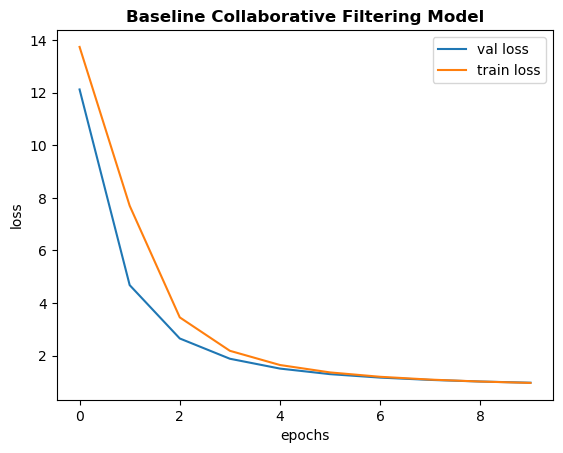

In [18]:
# baseline model loss plot in matplotlib
plt.plot(history.history['val_loss'], label="val loss")
plt.plot(history.history['loss'],  label="train loss")
plt.title('Baseline Collaborative Filtering Model', fontweight='bold')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
#plt.savefig(base_path + '/figures/plt/' + 'Baseline Collaborative Filtering Model.jpg',bbox_inches='tight')
plt.show()

In [19]:
# Load weights
model.load_weights(base_path + '//data//' + 'baseline2_weights.h5')
model.summary()

Model: "output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user-embed (Embedding)         (None, 1, 128)       773120      ['input_1[0][0]']                
                                                                                                  
 movie-embed (Embedding)        (None, 1, 128)       505856      ['input_2[0][0]']                
                                                                                             

In [20]:
TEST_USER=1500

In [21]:
users[users['user_id'] == TEST_USER]

,user_id,gender,zipcode,age_desc,occ_desc
1499,1500,M,98115,25-34,technician/engineer


In [37]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(model, user_id, movie_id):
    return model.predict([np.array([user_id]), np.array([movie_id])],verbose=0)[0][0]

In [38]:
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(model, TEST_USER, x['movie_id']),axis=1)

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 9ms/epoch - 9ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 9ms/epoch - 9ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 9ms/epoch - 9ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 9ms/epoch - 9ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 10ms/epoch - 10ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 9ms/epoch - 9ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 - 0s - 8ms/epoch - 8ms/step
1/1 - 0s - 7ms/epoch - 7ms/step
1/1 

In [32]:
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner'
                                                ).head(20)

,user_id,movie_id,rating,prediction,title,genres
0,1500,1240,5,2.742100,"Terminator, The (1984)",Action|Sci-Fi|Thriller
1,1500,231,5,4.534015,Dumb & Dumber (1994),Comedy
2,1500,2683,5,0.097749,Austin Powers: The Spy Who Shagged Me (1999),Comedy
3,1500,296,5,1.141945,Pulp Fiction (1994),Crime|Drama
4,1500,2858,5,4.741787,American Beauty (1999),Comedy|Drama
5,1500,1136,5,-0.009148,Monty Python and the Holy Grail (1974),Comedy
6,1500,1307,5,-0.086292,When Harry Met Sally... (1989),Comedy|Romance
7,1500,3911,5,1.501654,Best in Show (2000),Comedy
8,1500,1199,5,4.152381,Brazil (1985),Sci-Fi
9,1500,3897,5,1.982262,Almost Famous (2000),Comedy|Drama


In [33]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(model, TEST_USER, x['movie_id']), axis=1)


In [34]:
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner'
                                                 ).head(20)

,movie_id,prediction,title,genres
0,744,4.961079,Brothers in Trouble (1995),Drama
1,1177,4.960043,Enchanted April (1991),Drama
2,1147,4.948443,When We Were Kings (1996),Documentary
3,921,4.917158,My Favorite Year (1982),Comedy
4,3021,4.904409,"Funhouse, The (1981)",Horror
5,3088,4.903151,Harvey (1950),Comedy
6,2018,4.894226,Bambi (1942),Animation|Children's
7,3029,4.889047,Nighthawks (1981),Action|Drama
8,3428,4.882945,"Champ, The (1979)",Drama
9,1211,4.881031,Wings of Desire (Der Himmel über Berlin) (1987),Comedy|Drama|Romance
